In [1]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from collections import namedtuple

from pa_lib.file import (
    project_dir,
    load_bin,
    write_xlsx,
    store_bin,
)
from pa_lib.data import as_dtype, dtFactor, desc_col, lookup, clean_up_categoricals
from pa_lib.util import (
    collect,
    value,
    flatten,
    normalize_rows,
    normalize_cols,
    list_items,
)
from pa_lib.log import time_log

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 300)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

# Load data

In [2]:
with project_dir("axinova"):
    ax_data = load_bin("ax_data.feather")
    ax_var_struct = load_bin("ax_var_struct.feather")

Variable = namedtuple("Variable", ["Label", "Codes", "Order"])

var_info = {}
for var, data in ax_var_struct.groupby("Variable"):
    var_info[var] = Variable(
        data["Variable_Label"].max(),
        data["Label"].to_list(),
        data["Label_Nr"].to_list(),
    )

18:19:13 [INFO] Started loading binary file ...
18:19:13 [INFO] Reading from file C:\Users\kpf\data\axinova\ax_data.feather
18:19:13 [INFO] ... finished loading binary file in 0.47s (1.02s CPU)
18:19:13 [INFO] Started loading binary file ...
18:19:13 [INFO] Reading from file C:\Users\kpf\data\axinova\ax_var_struct.feather
18:19:13 [INFO] ... finished loading binary file in 0.0s (0.0s CPU)


In [3]:
def var_label(variable):
    return var_info[variable].Label


def var_codes(variable):
    return var_info[variable].Codes

In [4]:
weekday_order = ax_data["DayOfWeek"].cat.categories.to_list()
workdays = weekday_order[:5]
weekend = weekday_order[5:]

timeSlot_order = ax_data["TimeSlot"].cat.categories.to_list()
day = timeSlot_order[1:]
rush_hours = list_items(timeSlot_order, [1, 5])
day_no_rush = list_items(timeSlot_order, [2, 3, 4, 6])

stations_d = [
    "Aarau",
    "Basel SBB",
    "Bern",
    "Biel/Bienne",
    "Brig",
    "Chur",
    "Luzern",
    "Olten",
    "St. Gallen",
    "Winterthur",
    "Zug",
    "Zürich Enge",
    "Zürich Flughafen",
    "Zürich Flughafen - Airside",
    "Zürich Flughafen - Landside",
    "Zürich HB",
    "Zürich Hardbrücke",
    "Zürich Oerlikon",
    "Zürich Stadelhofen",
]
stations_f = [
    "Biel/Bienne",
    "Fribourg",
    "Genève Aéroport",
    "Genève Cornavin",
    "Lausanne",
    "M2",
    "Neuchatel",
]
stations_i = ["Bellinzona", "Lugano"]

In [5]:
ax_data.head()

,Station,DayOfWeek,Time,Variable,Code,Value,Year,Month,logValue,VarDesc,TimeSlot,ShortTime,Hour,is_weekend,is_day,is_rush,is_day_no_rush,TimeSlot_cat,StationSprache
0,Aarau,Monday,00:15 - 00:30,g_220,Keines,0.954451,2019,05,0.670109,Anzahl Autos im Haushalt,Nacht,00:15,00,False,False,False,False,Night,Deutsch
1,Aarau,Monday,00:15 - 00:30,g_500,quoted,0.954451,2019,05,0.670109,Zeitung: 20 Minuten / 20 Minutes / 20 Minuti,Nacht,00:15,00,False,False,False,False,Night,Deutsch
2,Aarau,Monday,00:15 - 00:30,g_501,not quoted,0.954451,2019,05,0.670109,Zeitung: Blick,Nacht,00:15,00,False,False,False,False,Night,Deutsch
3,Aarau,Monday,00:15 - 00:30,g_502,not quoted,0.954451,2019,05,0.670109,Zeitung: Tages-Anzeiger,Nacht,00:15,00,False,False,False,False,Night,Deutsch
4,Aarau,Monday,00:15 - 00:30,g_503,not quoted,0.954451,2019,05,0.670109,Zeitung: Mittelland Zeitung,Nacht,00:15,00,False,False,False,False,Night,Deutsch


# Define functions

## Select data

In [6]:
def _check_selection(data, selection, allowed_columns):
    allowed_values = {}
    for column in allowed_columns:
        allowed_values[column] = data[column].cat.categories
    if set(selection.keys()) - set(allowed_columns) != set():
        raise NameError(f"Unknown column name in selection: {selection.keys()}")
    clean_selection = {}
    for column in allowed_columns:
        if column in selection:
            col_values = list(flatten(selection[column]))
            if set(col_values) - set(allowed_values[column]) != set():
                raise ValueError(
                    f"Illegal value(s) in parameter {column}: {col_values}"
                )
            clean_selection[column] = col_values
        else:
            clean_selection[column] = None
    return clean_selection


def select_data(all_data, **selection):
    select_columns = "DayOfWeek Station Variable Month TimeSlot Hour Time TimeSlot_cat StationSprache".split()
    selection = _check_selection(all_data, selection, allowed_columns=select_columns)
    row_mask = pd.Series([True] * all_data.shape[0])
    for col in select_columns:
        if selection[col] is not None:
            row_mask &= all_data[col].isin(selection[col])
    return all_data.loc[row_mask].pipe(clean_up_categoricals).reset_index(drop=True)

In [7]:
select_data(ax_data, DayOfWeek="Monday", Station="Aarau")

,Station,DayOfWeek,Time,Variable,Code,Value,Year,Month,logValue,VarDesc,TimeSlot,ShortTime,Hour,is_weekend,is_day,is_rush,is_day_no_rush,TimeSlot_cat,StationSprache
0,Aarau,Monday,00:15 - 00:30,g_220,Keines,0.954451,2019,05,0.670109,Anzahl Autos im Haushalt,Nacht,00:15,00,False,False,False,False,Night,Deutsch
1,Aarau,Monday,00:15 - 00:30,g_500,quoted,0.954451,2019,05,0.670109,Zeitung: 20 Minuten / 20 Minutes / 20 Minuti,Nacht,00:15,00,False,False,False,False,Night,Deutsch
2,Aarau,Monday,00:15 - 00:30,g_501,not quoted,0.954451,2019,05,0.670109,Zeitung: Blick,Nacht,00:15,00,False,False,False,False,Night,Deutsch
3,Aarau,Monday,00:15 - 00:30,g_502,not quoted,0.954451,2019,05,0.670109,Zeitung: Tages-Anzeiger,Nacht,00:15,00,False,False,False,False,Night,Deutsch
4,Aarau,Monday,00:15 - 00:30,g_503,not quoted,0.954451,2019,05,0.670109,Zeitung: Mittelland Zeitung,Nacht,00:15,00,False,False,False,False,Night,Deutsch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56193,Aarau,Monday,23:45 - 00:00,md_wohneigentum,Mieter,1.126940,2019,11,0.754684,Eigentümer versus Mieter,Nacht,23:45,23,False,False,False,False,Night,Deutsch
56194,Aarau,Monday,23:45 - 00:00,md_zivil,geschieden,1.126940,2019,11,0.754684,Zivilstand,Nacht,23:45,23,False,False,False,False,Night,Deutsch
56195,Aarau,Monday,23:45 - 00:00,md_zivil,ledig,1.015517,2019,08,0.700876,Zivilstand,Nacht,23:45,23,False,False,False,False,Night,Deutsch
56196,Aarau,Monday,23:45 - 00:00,nat_ausland,not quoted,1.126940,2019,11,0.754684,Nationalität Ausland,Nacht,23:45,23,False,False,False,False,Night,Deutsch


## Display selection as pivot table (Codes vs. Time) and heatmap

In [8]:
from scipy.stats import chi2_contingency


def _cont_table(var, data, index_by, aggfunc):
    all_codes = var_codes(var)
    observed_codes = (
        pd.Series(all_codes)
        .loc[pd.Series(all_codes).isin(data["Code"].unique())]
        .values
    )
    cont_table = data.pivot_table(
        index=index_by,
        columns="Code",
        values="Value",
        aggfunc=aggfunc,
        margins=False,
        fill_value=0,
    ).loc[:, observed_codes]
    return cont_table


def _show_chisq(var, actual, counts, resid_type):
    (_, p_val, _, expected) = chi2_contingency(actual)
    if resid_type == "absolute":
        residuals = actual - expected
    elif resid_type == "percent":
        residuals = (actual / expected * 100) - 100
    else:
        raise ValueError(
            f"Parameter resid_type not in ('absolute', 'percent') ('{resid_type}')"
        )
    (plot_rows, plot_cols) = residuals.shape
    plt.figure(figsize=(plot_cols * 2, plot_rows))
    plt.title(f"Abweichung: {var_label(var)} ({var}), p={round(p_val, 4)}", pad=12)
    annotations = residuals.round(1).values
    sns.heatmap(
        data=residuals,
        center=0,
        annot=annotations,
        linewidths=0,
        robust=True,
        fmt=".1f",
    )


def show_code_cont_tables(
    selection,
    index_by,
    aggfunc="sum",
    show_agg=True,
    show_normal=False,
    show_chisq=False,
    chisq_resid="absolute",
):
    data = select_data(ax_data, **selection)
    for var, subset in data.groupby("Variable"):
        # calculate contingency table
        prop_table = _cont_table(var, subset, index_by, aggfunc)
        count_table = _cont_table(var, subset, index_by, aggfunc="size")

        # show results
        if show_agg or show_normal:
            print(f"Variable: {var_label(var)} ({var})")
            print(
                "Selection: "
                + ", ".join(f"{col} = {values}" for col, values in selection.items())
            )
        if show_agg:
            display(prop_table.round(1))
        if show_normal:
            print("Code percentages:")
            display(normalize_rows(prop_table).round(3) * 100)
        if show_chisq:
            _show_chisq(
                var, actual=prop_table, counts=count_table, resid_type=chisq_resid,
            )

Variable: Haushaltsbruttoeinkommen pro Monat (md_ek)
Selection: DayOfWeek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], Station = Zürich HB, Variable = ['md_ek']


Code,Keine Angabe,Weniger als 3'000 CHF,Zwischen 3'000 und 4'500 CHF,Zwischen 4'501 und 6'000 CHF,Zwischen 6'001 und 9'000 CHF,Zwischen 9'001 und 12'000 CHF,Mehr als 12'000 CHF
TimeSlot,,,,,,,
Nacht,107.5,49.8,52.3,138.2,289.0,187.9,440.3
Morgen-Rush,744.8,563.6,266.4,736.1,1729.0,1566.6,2927.3
Morgen,309.0,177.6,231.9,349.4,682.7,806.0,784.8
Mittag,561.9,201.6,211.4,354.7,831.5,880.7,920.1
Nachmittag,598.7,309.7,402.5,443.9,1441.5,1267.1,1312.9
Abend-Rush,1188.9,742.3,655.6,996.6,3027.0,2596.8,3658.9
Abend,586.9,459.5,462.6,739.0,1507.5,1182.7,1570.9


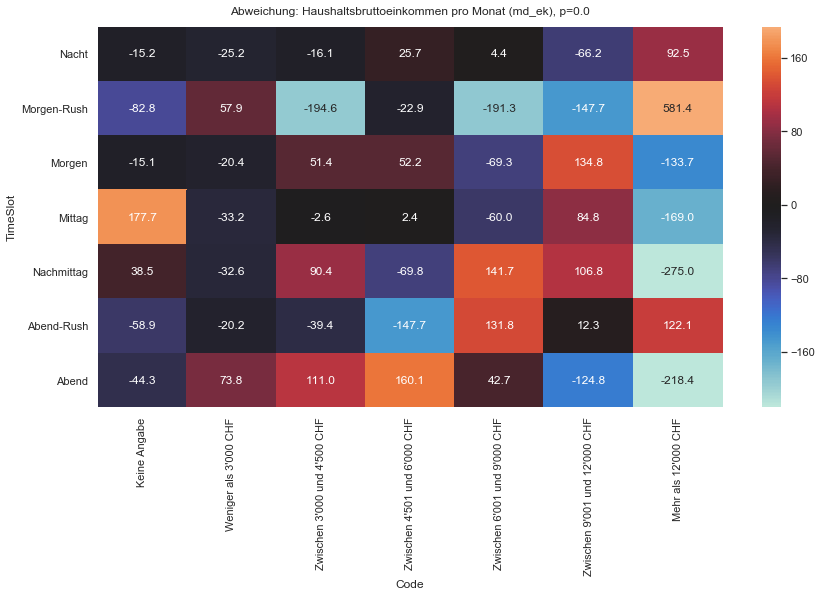

In [10]:
def _per_quarter(s):
    return s.sum() / s.size


def _extrapolate(s):
    return _per_quarter(s) * 4250


show_code_cont_tables(
    selection=dict(
        DayOfWeek=workdays, Station="Zürich HB", Variable=["md_ek"],
    ),
    index_by=["TimeSlot"],
    aggfunc="sum",
    show_chisq=True,
    chisq_resid="absolute",
)

## Estimate cell median and confidence intervals (quantiles)

In [11]:
from scipy.stats import chi2_contingency


def var_factor_dependance(data, variable, factor, partitions):
    subset = data.loc[data.Variable == variable].pipe(clean_up_categoricals)
    result = pd.DataFrame(columns=["Var", "Label", f"p_{factor}"])
    for label, partition in subset.groupby(partitions, observed=True):
        result_row = {"Var": variable, "Label": label}
        contingency_tab = partition.pivot_table(
            index="Code", columns=factor, aggfunc="size", fill_value=0, observed=True
        )
        p_factor = chi2_contingency(contingency_tab)[1]
        result_row[f"p_{factor}"] = p_factor
        result = result.append(result_row, ignore_index=True, sort=False)
    return result

In [12]:
def quartiles(s):
    try:
        (q25, med, q75) = np.percentile(s, [25, 50, 75])
        iqr = q75 - q25
        # return [q25 - 1.5 * iqr, med, q75 + 1.5 * iqr]  # Tukey's outlier limits
        return [q25, med, q75]  # quartiles
    except:
        return -1


def log_ci(s):
    try:
        log_series = np.log1p(s)
        log_mean = np.mean(log_series)
        log_std = np.std(log_series)
        (lo, md, hi) = log_mean - log_std, log_mean, log_mean + log_std
        return list(np.expm1((lo, md, hi)))
    except:
        return -1

In [13]:
selection = dict(DayOfWeek=workdays, Variable=["md_ek"], Station=stations_d,)

show_code_cont_tables(selection, index_by="TimeSlot", aggfunc=log_ci)

Variable: Haushaltsbruttoeinkommen pro Monat (md_ek)
Selection: DayOfWeek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], Variable = ['md_ek'], Station = ['Aarau', 'Basel SBB', 'Bern', 'Biel/Bienne', 'Brig', 'Chur', 'Luzern', 'Olten', 'St. Gallen', 'Winterthur', 'Zug', 'Zürich Enge', 'Zürich Flughafen', 'Zürich Flughafen - Airside', 'Zürich Flughafen - Landside', 'Zürich HB', 'Zürich Hardbrücke', 'Zürich Oerlikon', 'Zürich Stadelhofen']


Code,Keine Angabe,Weniger als 3'000 CHF,Zwischen 3'000 und 4'500 CHF,Zwischen 4'501 und 6'000 CHF,Zwischen 6'001 und 9'000 CHF,Zwischen 9'001 und 12'000 CHF,Mehr als 12'000 CHF
TimeSlot,,,,,,,
Nacht,"[0.7590530195862448, 1.1562445340972385, 1.6431212925678742]","[0.8838036614223139, 1.1516628926459993, 1.4576091969660236]","[0.7716990365224516, 1.0994268191980079, 1.487777482692112]","[0.8420660460138183, 1.2577533487865202, 1.7672461554717285]","[0.7654046144487638, 1.2460552153127993, 1.8575681681952672]","[0.7422012814798582, 1.2242936440554022, 1.8397879553749248]","[0.7629689440570948, 1.3332896547155788, 2.0881091984944398]"
Morgen-Rush,"[0.8044633407431816, 1.7281682691713036, 3.124717824329827]","[0.8192431057833165, 1.6523504091386432, 2.8669722977066696]","[0.7789072674351059, 1.5584042671310185, 2.679468016065644]","[0.8523115169315996, 1.6282380470012008, 2.729197366945791]","[0.8902008133000223, 1.943251747746706, 3.582968534168675]","[0.8837236189921167, 1.9365578318738264, 3.577832869427751]","[0.9367577284074595, 2.2174469111146933, 4.3449971950563]"
Morgen,"[0.7463680624033922, 1.291232399864505, 2.00609363123833]","[0.8262670711760116, 1.2401829170082155, 1.747911069996933]","[0.8449739134114274, 1.3461187738686586, 1.9833881449962436]","[0.7518835145143261, 1.335968113796441, 2.114788730794395]","[0.7864255357379524, 1.5287470570011439, 2.5795288134696444]","[0.7861445538494527, 1.5288025685430195, 2.5802490995971037]","[0.7965703556236097, 1.5227660182478822, 2.5424988300094356]"
Mittag,"[0.7780565886651447, 1.4816093960148011, 2.463548479642193]","[0.7815510471219405, 1.2327303844560609, 1.7981712776216048]","[0.8194316384733247, 1.3868931745679594, 2.1313399780052475]","[0.762202818531533, 1.369294266840725, 2.1855330520706917]","[0.7999542777322592, 1.6415656327552148, 2.8766923573996515]","[0.7749451152671034, 1.6210887638861204, 2.870602109934098]","[0.7813294633960439, 1.567508706800365, 2.7006635184308165]"
Nachmittag,"[0.7748357365905125, 1.3860901416143072, 2.2078609003254277]","[0.7961028877577945, 1.378790100383695, 2.1505112431212465]","[0.8047234213807091, 1.34771047904963, 2.0540660292548685]","[0.7478161999403421, 1.3432375945768649, 2.141498759895798]","[0.8023507033295947, 1.6108170628328153, 2.7819308545149797]","[0.7925969125961914, 1.5890736546525965, 2.7394365359627115]","[0.8267914327385206, 1.651448431212018, 2.8483751660898786]"
Abend-Rush,"[0.8447961466798799, 1.739493299842482, 3.0681045184252183]","[0.8217603603606933, 1.4821959195781713, 2.382056563109452]","[0.8200589895846988, 1.4887078002555678, 2.4030031721478315]","[0.8373691896570461, 1.618476112053159, 2.731649136161259]","[0.8876136406816104, 2.103808454633958, 4.103601031182722]","[0.8764914914464688, 2.045745497802432, 3.9435692512695946]","[0.9497651091707973, 2.3321958319192913, 4.694803445827607]"
Abend,"[0.766007143462645, 1.2932153407050992, 1.977811623419654]","[0.8110514662525186, 1.2615177898581438, 1.8240294708067357]","[0.8437947400265202, 1.3751282497288173, 2.0595782058575205]","[0.7796901078949141, 1.3046505212119035, 1.9844600480500754]","[0.7893124487789585, 1.529526245010071, 2.5759562442887716]","[0.7710676855773813, 1.4185797463768481, 2.3028257684444795]","[0.783111376583572, 1.5172662299461432, 2.5536923579996467]"


## Visualize estimations with confidence intervals

In [14]:
def plot_estimates(
    data,
    target,
    time_scale,
    plot_kind,
    plot_ci=100,
    heatmap_aggr="sum",
    heatmap_display_table=False,
    heatmap_norm=None,
):
    def _calc_heatmap(data, columns, **kwargs):
        heatmap = data.pivot_table(
            values=target,
            index=time_scale,
            columns="Code",
            aggfunc=heatmap_aggr,
            fill_value=0,
            observed=True,
            **kwargs,
        )
        if heatmap_norm == "Time":
            heatmap = normalize_rows(heatmap) * 100
        elif heatmap_norm == "Code":
            heatmap = normalize_cols(heatmap) * 100
        elif heatmap_norm == "both":
            heatmap = heatmap / heatmap.values.sum() * 100
        elif heatmap_norm is not None:
            raise ValueError(
                f"Parameter heatmap_norm must be one of [None, 'Time', 'Code', 'both'], is '{heatmap_norm}'"
            )
        heatmap_cols = list(filter(lambda col: col in heatmap.columns, columns))
        return heatmap.loc[:, heatmap_cols]

    for (var, data_subset) in data.groupby("Variable"):
        if plot_kind == "box":
            grid = sns.FacetGrid(
                data_subset, col=time_scale, col_wrap=3, height=4, aspect=1.5
            )
            grid.map(sns.boxenplot, "Code", target, order=var_codes(var))
            grid.fig.tight_layout(w_pad=1)
        elif plot_kind == "bar":
            grid = sns.FacetGrid(
                data_subset, col=time_scale, col_wrap=3, height=4, aspect=1.5
            )
            grid.map(sns.barplot, "Code", target, order=var_codes(var), ci=plot_ci)
            grid.fig.tight_layout(w_pad=1)
        elif plot_kind == "point":
            grid = sns.FacetGrid(
                data_subset, col=time_scale, col_wrap=3, height=4, aspect=1.5
            )
            grid.map(
                sns.pointplot,
                "Code",
                target,
                order=var_codes(var),
                ci=plot_ci,
                join=False,
                errwidth=2,
                capsize=0.1,
            )
            grid.fig.tight_layout(w_pad=1)
        elif plot_kind == "heatmap":
            plot_values = _calc_heatmap(data=data_subset, columns=var_codes(var),)
            (plot_rows, plot_cols) = plot_values.shape
            plt.figure(figsize=(plot_cols * 2, plot_rows))
            plt.title(f"{heatmap_aggr} of {var_label(var)} ({var})", pad=12)
            annotations = plot_values.round(1).values
            sns.heatmap(
                data=plot_values,
                center=0,
                annot=annotations,
                linewidths=0,
                robust=True,
                fmt=".1f",
            )
            if heatmap_display_table:
                display(
                    _calc_heatmap(
                        data=data_subset,
                        columns=var_codes(var) + ["Total"],
                        margins=True,
                        margins_name="Total",
                    ).round(1)
                )
        else:
            raise ValueError("Unknown plot_kind")

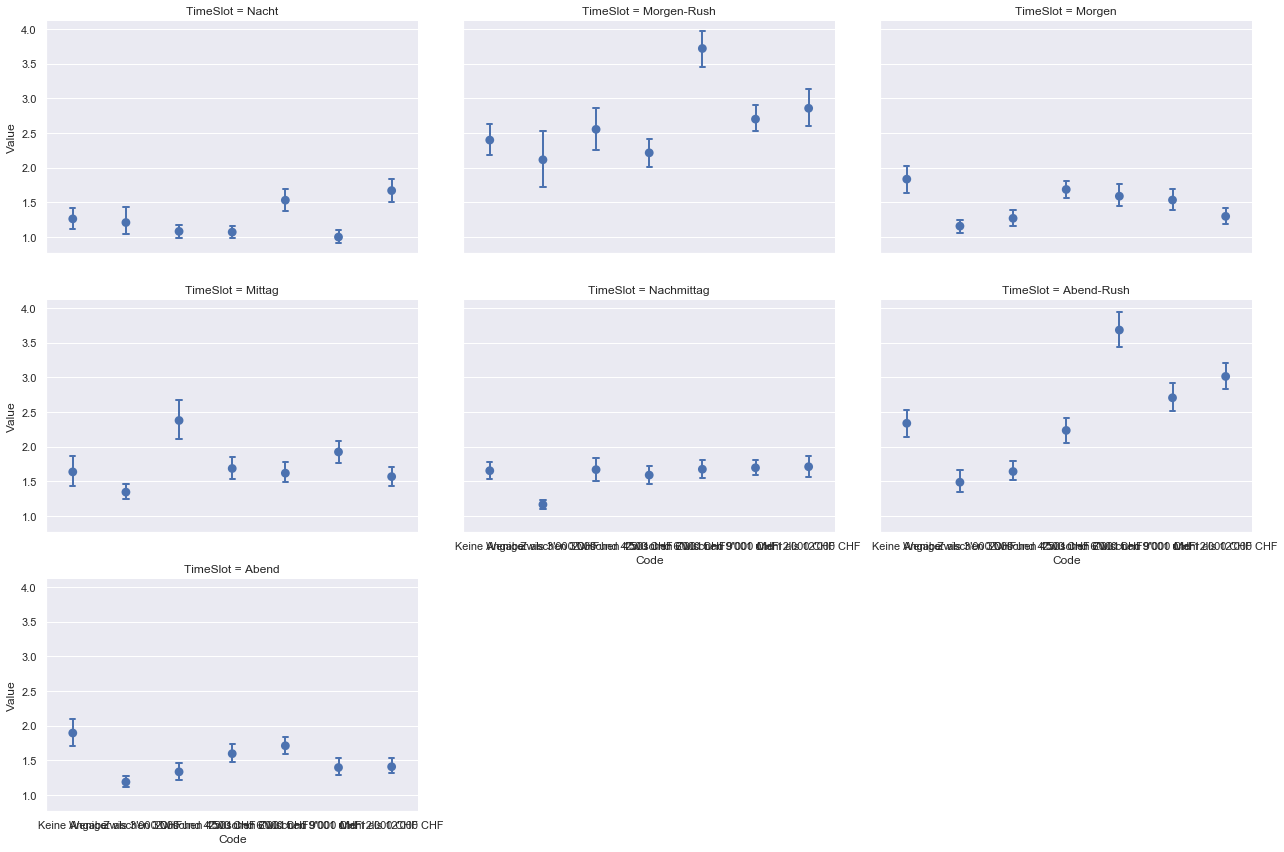

In [16]:
selection = dict(Station="Lausanne", Variable=["md_ek"], DayOfWeek=workdays,)

plot_estimates(
    data=select_data(ax_data, **selection),
    target="Value",
    time_scale="TimeSlot",
    plot_kind="point",
    plot_ci=95,
    heatmap_aggr="sum",
    heatmap_display_table=False,
    heatmap_norm="both",
)

## Chi-Square residuals

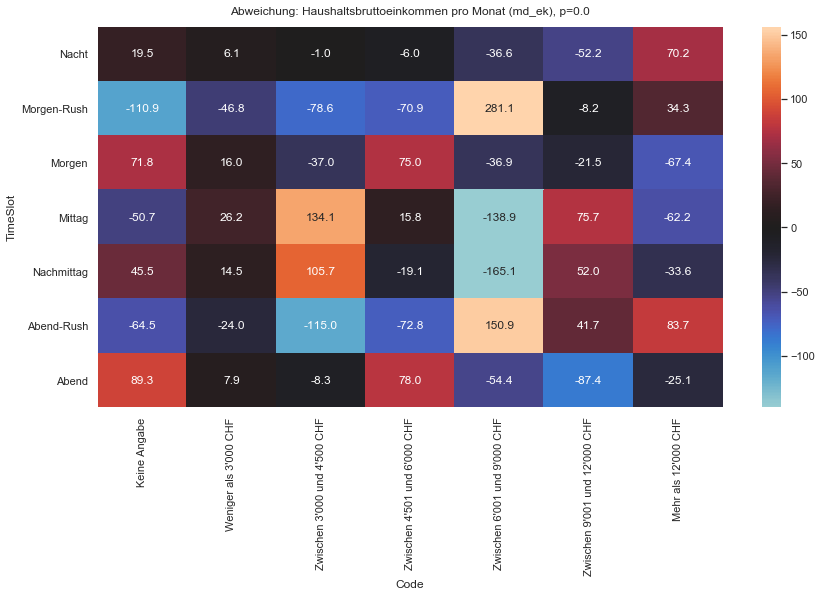

In [17]:
def _per_quarter(s):
    return s.sum() / s.size


def _extrapolate(s):
    return _per_quarter(s) * 4250


show_code_cont_tables(
    selection=dict(DayOfWeek=workdays, Station="Lausanne", Variable=["md_ek"]),
    index_by=["TimeSlot"],
    aggfunc="sum",
    show_agg=False,
    show_chisq=True,
    chisq_resid="absolute",
)